In [1]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
import os
from collections import defaultdict

from IPython.display import clear_output


matplotlib.rcParams['figure.figsize'] = (20, 5)

In [2]:
DATA_ROOT = Path('/mnt/ssd1/datasets/alexkkir/birds')
images_path = DATA_ROOT / '00_test_img_input' / 'train' / 'images'
labels_path = DATA_ROOT / '00_test_img_input' / 'train' / 'gt.csv'

In [3]:
class MyImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.images = []
        for sample in self.samples:
            path = sample[0]
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            self.images.append(image)
            
    def __getitem__(self, index):
        path_x, y = self.samples[index]
        # x = self.loader(path_x)
        x = self.images[index]
        if self.transform is not None:
            x = np.array(x)
            x = self.transform(image=x)['image']

        if self.target_transform is not None:
            y = self.target_transform(y)

        return x, y, path_x.split('/')[-1]

Изначально я делал ресайз до 224 вместо 310((( Возможно, если бы я это исправил, стало получше

In [4]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])


transform = A.Compose([
    A.Resize(310, 310),
    A.HorizontalFlip(p=0.3),
    A.Rotate(p=0.35, limit=15),
    A.RingingOvershoot(p=0.2, blur_limit=(3, 7)),
    A.OneOf([
        A.HueSaturationValue(p=0.3),
        A.RGBShift(p=0.3),
        A.Compose([ 
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
            A.CLAHE(p=0.5),
        ], p=1)
    ], p=0.5),
    A.Affine(scale=(0.85, 1), translate_percent=(0, 0.10), shear=(-4, 4), p=0.35),
    A.Normalize(MEAN, STD),
    ToTensorV2(),
])

dataset = MyImageFolder(DATA_ROOT / 'data', transform=transform)
targets = dataset.targets

train_idx, valid_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=targets
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16)

Функция которая тупо выполняет прогон модели по всему батчу. Но кроме этого, она выполняет типо ассамблирование - пропускает каждую картинку с разными искажениями через нейронку

In [11]:
def test_on_dataloader(model, loader, repeats=3):
    device = torch.device('cuda:0')
    model = model.to(device)
    model.eval()
    correct = defaultdict()
    predicted = defaultdict(list)
    for repeat in range(repeats):
        for batch in loader:
            images, labels, names = batch
            for name, label in zip(names, labels):
                correct[name] = label

            images = images.to(device)
            pred = model.forward(images).detach().cpu()
            pred = F.softmax(pred, dim=1).argmax(dim=1)

            for name, p in zip(names, pred):
                predicted[name].append(p)

    predicted_most_common = {}
    for name, preds in predicted.items():
        most_common = max(set(preds), key=preds.count)
        predicted_most_common[name] = most_common

    n = 0
    for k in correct:
        true = correct[k]
        pred = predicted_most_common[k]
        n += true == pred
    n = float(n) / len(correct)

    acc_mean = n

    acc_single = []
    for i in range(repeats):
        n = 0
        for k in correct:
            true = correct[k]
            pred = predicted[k][i]
            n += true == pred
        n = float(n) / len(correct)

        acc_single.append(n)
    return acc_mean, acc_single

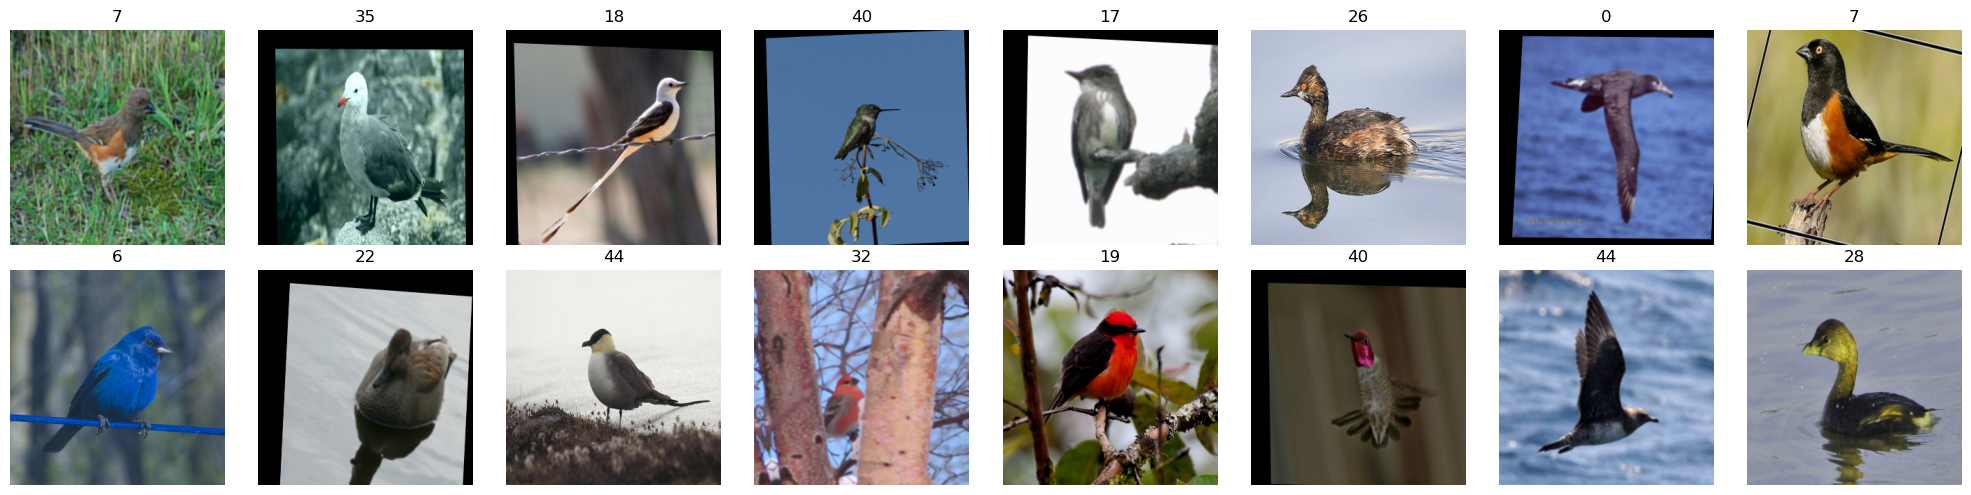

In [6]:
def display_batch(batch, cols=8):
    rows = ceil(len(batch[0]) / cols)
    fig_size = matplotlib.rcParams['figure.figsize'][0] / cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (fig_size * cols, fig_size * rows))
    for i, image in enumerate(batch[0]):
        image = image.permute(1, 2, 0)
        image = image * STD + MEAN
        predicted_label = int(batch[1][i])
        color = 'black'
        ax.ravel()[i].imshow((image * 255).type(torch.uint8))
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_batch(next(iter(train_loader)))

In [7]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        features = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        features = list(features.children())[:-2]
        features = nn.Sequential(*features)

        self.features = features
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.8),
            nn.Linear(1280 , 500),
            nn.SiLU(),
            nn.Dropout(0.8),
            nn.Linear(500, 50),
        )

        self.loss = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.acc = lambda pred, y: torch.sum(F.softmax(pred, dim=1).argmax(dim=1) == y) / y.shape[0]

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch[0], batch[1]

        pred = self(x)
        loss = self.loss(pred, y)
        
        acc = self.acc(pred, y)

        return {'loss': loss, 'acc': acc}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam([
            {'params': self.features.parameters(), 'lr': 3e-5 / 2},
            {'params': self.classifier.parameters()}
        ], lr=3e-4, weight_decay=3e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.2, 
            patience=5, 
            verbose=True)
            
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_acc"
        } 

        return [optimizer], [lr_dict]

    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch[0], batch[1]
        pred = self(x)
        loss = self.loss(pred, y)
        acc = self.acc(pred, y)

        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()

        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        print(f"[Epoch {self.trainer.current_epoch:3}] Val_acc: {avg_acc:.2f}, Val_loss: {avg_loss:.2f}", end= " ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

In [8]:
def freeze_model(model):
    for p in model.features.parameters():
        p.requires_grad = False

def unfreeze_model(model):
    for p in model.features.parameters():
        p.requires_grad = True

In [9]:
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_classifier',
                                    filename='{epoch}-{val_acc:.3f}',
                                    monitor='val_acc', 
                                    mode='max', 
                                    save_top_k=1,
                                    save_weights_only=True,
                                    verbose=False)

MyEarlyStopping = EarlyStopping(monitor = "val_acc",
                                mode = "max",
                                patience = 15,
                                verbose = True)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu',
    devices=[0],
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=1,
)

model = Model()
freeze_model(model)

trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alexkkir/anaconda3/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:601: UserWarning: Checkpoint directory /home/alexkkir/cv-hw3-birds/runs/pl_classifier exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 20.2 M
1 | classifier | Sequential       | 665 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
665 K     Trainable params
20.2 M    Non-trainable params
20.8 M    Total params
83.372    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[Epoch   0] Val_acc: 0.06, Val_loss: 3.91 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.340


[Epoch   0] Val_acc: 0.34, Val_loss: 3.68 | Train_acc: 0.05, Train_loss: 3.85


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.090 >= min_delta = 0.0. New best score: 0.430


[Epoch   1] Val_acc: 0.43, Val_loss: 3.38 | Train_acc: 0.15, Train_loss: 3.59


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.021 >= min_delta = 0.0. New best score: 0.451


[Epoch   2] Val_acc: 0.45, Val_loss: 3.07 | Train_acc: 0.22, Train_loss: 3.30


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.461


[Epoch   3] Val_acc: 0.46, Val_loss: 2.76 | Train_acc: 0.25, Train_loss: 3.03


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.045 >= min_delta = 0.0. New best score: 0.506


[Epoch   4] Val_acc: 0.51, Val_loss: 2.55 | Train_acc: 0.30, Train_loss: 2.81


/home/alexkkir/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
test_on_dataloader(model, valid_loader, 3)

(0.518, [0.514, 0.504, 0.494])

После того как моделька хорошо обучила полносвязные слои, я ее целиком размораживаю и файнтюню 

In [13]:
class ChangeOptimizer(pl.Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == 0:
            lr = 3e-4
            lr_backbone_frac = 0.1
            optimizer = torch.optim.Adam([
                {'params': trainer.model.features.parameters(), 'lr': lr * lr_backbone_frac},
                {'params': trainer.model.classifier.parameters()}
            ], lr=lr, weight_decay=3e-4)      

            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, 
                mode='max', 
                factor=0.2, 
                patience=5, 
                verbose=True)
            
            lr_dict = {
                # REQUIRED: The scheduler instance
                "scheduler": lr_scheduler,
                # The unit of the scheduler's step size, could also be 'step'.
                # 'epoch' updates the scheduler on epoch end whereas 'step'
                # updates it after a optimizer update.
                "interval": "epoch",
                # How many epochs/steps should pass between calls to
                # `scheduler.step()`. 1 corresponds to updating the learning
                # rate after every epoch/step.
                "frequency": 1,
                # Metric to monitor for schedulers like `ReduceLROnPlateau`
                "monitor": "val_acc"
            } 
        
            trainer.optimizers = [optimizer]
            trainer.lr_schedulers = [lr_dict]
            trainer.optimizer_frequencies = [] # or optimizers frequencies if you have any

In [15]:
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_classifier',
                                    filename='{epoch}-{val_acc:.3f}',
                                    monitor='val_acc', 
                                    mode='max', 
                                    save_top_k=1,
                                    save_weights_only=True,
                                    verbose=False)

MyEarlyStopping = EarlyStopping(monitor = "val_acc",
                                mode = "max",
                                patience = 15,
                                verbose = True)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu',
    devices=[0],
    callbacks=[ChangeOptimizer(), MyModelCheckpoint, MyEarlyStopping],
    # callbacks=[MyModelCheckpoint, MyEarlyStopping],
    log_every_n_steps=1
)


model = Model.load_from_checkpoint('/home/alexkkir/cv-hw3-birds/runs/pl_classifier/epoch=4-val_acc=0.506.ckpt', map_location='cpu')
print(test_on_dataloader(model, valid_loader, 1))
unfreeze_model(model)
trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 20.2 M
1 | classifier | Sequential       | 665 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
20.8 M    Trainable params
0         Non-trainable params
20.8 M    Total params
83.372    Total estimated model params size (MB)


(0.508, [0.508])


Sanity Checking: 0it [00:00, ?it/s]

[Epoch   0] Val_acc: 0.56, Val_loss: 2.52 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.613


[Epoch   0] Val_acc: 0.61, Val_loss: 1.92 | Train_acc: 0.38, Train_loss: 2.47


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.068 >= min_delta = 0.0. New best score: 0.682


[Epoch   1] Val_acc: 0.68, Val_loss: 1.68 | Train_acc: 0.48, Train_loss: 2.16


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.057 >= min_delta = 0.0. New best score: 0.738


[Epoch   2] Val_acc: 0.74, Val_loss: 1.53 | Train_acc: 0.56, Train_loss: 1.95


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.033 >= min_delta = 0.0. New best score: 0.771


[Epoch   3] Val_acc: 0.77, Val_loss: 1.38 | Train_acc: 0.62, Train_loss: 1.77


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.791


[Epoch   4] Val_acc: 0.79, Val_loss: 1.30 | Train_acc: 0.68, Train_loss: 1.65


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.799


[Epoch   5] Val_acc: 0.80, Val_loss: 1.28 | Train_acc: 0.73, Train_loss: 1.53


Validation: 0it [00:00, ?it/s]

[Epoch   6] Val_acc: 0.79, Val_loss: 1.25 | Train_acc: 0.76, Train_loss: 1.47


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.018 >= min_delta = 0.0. New best score: 0.816


[Epoch   7] Val_acc: 0.82, Val_loss: 1.22 | Train_acc: 0.80, Train_loss: 1.39


Validation: 0it [00:00, ?it/s]

[Epoch   8] Val_acc: 0.82, Val_loss: 1.20 | Train_acc: 0.82, Train_loss: 1.34


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.027 >= min_delta = 0.0. New best score: 0.844


[Epoch   9] Val_acc: 0.84, Val_loss: 1.15 | Train_acc: 0.85, Train_loss: 1.29


Validation: 0it [00:00, ?it/s]

[Epoch  10] Val_acc: 0.84, Val_loss: 1.15 | Train_acc: 0.86, Train_loss: 1.23


Validation: 0it [00:00, ?it/s]

[Epoch  11] Val_acc: 0.84, Val_loss: 1.17 | Train_acc: 0.89, Train_loss: 1.19


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.855


[Epoch  12] Val_acc: 0.86, Val_loss: 1.12 | Train_acc: 0.90, Train_loss: 1.16


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.857


[Epoch  13] Val_acc: 0.86, Val_loss: 1.09 | Train_acc: 0.91, Train_loss: 1.14


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.873


[Epoch  14] Val_acc: 0.87, Val_loss: 1.09 | Train_acc: 0.94, Train_loss: 1.10


Validation: 0it [00:00, ?it/s]

[Epoch  15] Val_acc: 0.87, Val_loss: 1.10 | Train_acc: 0.93, Train_loss: 1.09


Validation: 0it [00:00, ?it/s]

[Epoch  16] Val_acc: 0.87, Val_loss: 1.11 | Train_acc: 0.95, Train_loss: 1.06


Validation: 0it [00:00, ?it/s]

[Epoch  17] Val_acc: 0.87, Val_loss: 1.08 | Train_acc: 0.95, Train_loss: 1.03


Validation: 0it [00:00, ?it/s]

[Epoch  18] Val_acc: 0.87, Val_loss: 1.13 | Train_acc: 0.97, Train_loss: 1.01


Validation: 0it [00:00, ?it/s]

[Epoch  19] Val_acc: 0.85, Val_loss: 1.16 | Train_acc: 0.96, Train_loss: 1.01


Validation: 0it [00:00, ?it/s]

[Epoch  20] Val_acc: 0.86, Val_loss: 1.13 | Train_acc: 0.97, Train_loss: 0.99
Epoch 00021: reducing learning rate of group 0 to 3.0000e-06.
Epoch 00021: reducing learning rate of group 1 to 6.0000e-05.


Validation: 0it [00:00, ?it/s]

[Epoch  21] Val_acc: 0.87, Val_loss: 1.11 | Train_acc: 0.97, Train_loss: 0.98


Validation: 0it [00:00, ?it/s]

[Epoch  22] Val_acc: 0.85, Val_loss: 1.19 | Train_acc: 0.97, Train_loss: 0.97


Validation: 0it [00:00, ?it/s]

[Epoch  23] Val_acc: 0.86, Val_loss: 1.11 | Train_acc: 0.98, Train_loss: 0.95


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.883


[Epoch  24] Val_acc: 0.88, Val_loss: 1.10 | Train_acc: 0.98, Train_loss: 0.94


Validation: 0it [00:00, ?it/s]

[Epoch  25] Val_acc: 0.86, Val_loss: 1.15 | Train_acc: 0.99, Train_loss: 0.92


Validation: 0it [00:00, ?it/s]

[Epoch  26] Val_acc: 0.88, Val_loss: 1.12 | Train_acc: 0.98, Train_loss: 0.93


Validation: 0it [00:00, ?it/s]

[Epoch  27] Val_acc: 0.88, Val_loss: 1.11 | Train_acc: 0.99, Train_loss: 0.91


Validation: 0it [00:00, ?it/s]

[Epoch  28] Val_acc: 0.86, Val_loss: 1.14 | Train_acc: 0.99, Train_loss: 0.92


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.885


[Epoch  29] Val_acc: 0.88, Val_loss: 1.11 | Train_acc: 0.99, Train_loss: 0.90


Validation: 0it [00:00, ?it/s]

[Epoch  30] Val_acc: 0.88, Val_loss: 1.14 | Train_acc: 0.99, Train_loss: 0.90


Validation: 0it [00:00, ?it/s]

[Epoch  31] Val_acc: 0.87, Val_loss: 1.19 | Train_acc: 0.99, Train_loss: 0.90


Validation: 0it [00:00, ?it/s]

[Epoch  32] Val_acc: 0.86, Val_loss: 1.19 | Train_acc: 0.99, Train_loss: 0.89


Validation: 0it [00:00, ?it/s]

[Epoch  33] Val_acc: 0.86, Val_loss: 1.15 | Train_acc: 0.99, Train_loss: 0.90


Validation: 0it [00:00, ?it/s]

[Epoch  34] Val_acc: 0.87, Val_loss: 1.18 | Train_acc: 0.99, Train_loss: 0.89


In [16]:
test_on_dataloader(model, valid_loader, 3)

(0.882, [0.878, 0.854, 0.872])